In [1]:
import torch.nn as nn
import torch   
import spacy
from torchtext import data 
import pandas as pd
import re
import random
import torch.optim as optim

nlp = spacy.load('en')


In [2]:
df = pd.read_csv('data_maxrep.csv')

df = df.rename(columns={ df.columns[0]: "site", df.columns[1] : 'dutch', df.columns[2] : 'lang' })
df.loc[df.dutch == True,'dutch']= 1
df.loc[df.dutch == False,'dutch']= 0

df = df.drop(['lang'], axis=1)
df = df.astype({'site': 'string', 'dutch': 'int32'})

print(len(df['dutch']))
print(df['dutch'].sum())

def preprocess(x):
    x = x.replace('https://www.', '')
    x = x.replace('http://www.', '')
    x = x.replace('http://', '')
    x = x.replace('https://', '')

    x = x.replace('.php', '')
    x = x.replace('.json', '')
    x = x.replace('.html', '')
    x = x.replace('.htm', '')
    x = x.replace('1', '')
    x = x.replace('2', '')
    x = x.replace('3', '')
    x = x.replace('4', '')
    x = x.replace('5', '')
    x = x.replace('6', '')
    x = x.replace('7', '')
    x = x.replace('8', '')
    x = x.replace('9', '')
    x = x.replace('%', '')
    x =  re.split('[/\=\-_?\.&\+]', x) 
    return ' '.join([i for i in x if not i.isdigit() and len(i) > 1])

df['site'] = df['site'].apply(preprocess)

df.to_csv('train.csv', index=False)


157049
81627


In [3]:
TEXT = data.Field(tokenize='spacy', batch_first=True, include_lengths=True)
LABEL = data.LabelField(dtype = torch.float, batch_first=True)

/home/ruben/Documents/school/Master 1/information retrieval/ir/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/ruben/Documents/school/Master 1/information retrieval/ir/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [4]:
fields = [('text',TEXT),('label', LABEL)]

In [5]:
training_data=data.TabularDataset(path = 'train.csv',format = 'csv',fields = fields,skip_header = True)
train_data, valid_data = training_data.split(split_ratio=0.999, random_state = random.seed(2020)) #testing
TEXT.build_vocab(train_data,min_freq=3,vectors = "glove.6B.100d")  
LABEL.build_vocab(train_data)

/home/ruben/Documents/school/Master 1/information retrieval/ir/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/ruben/Documents/school/Master 1/information retrieval/ir/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
batch_size = 68
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), batch_size = batch_size, sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

/home/ruben/Documents/school/Master 1/information retrieval/ir/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [7]:

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden, output, n_layers, 
                 bidirectional, dropout):
        
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)

        self.fc = nn.Linear(hidden * 2, output)
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(),batch_first=True)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)        
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        fc_outputs=self.fc(hidden)
        outputs=self.act(fc_outputs)
        
        return outputs

In [8]:
embedding_dim = 100
n_layers = 2
size_of_vocab = len(TEXT.vocab)
n_hidden = 32
n_output = 1
bidir = True
dropout = 0.30 

model = classifier(size_of_vocab, embedding_dim, n_hidden, n_output, n_layers, 
                   bidir, dropout = dropout)
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2571, 0.0821, 1.0800,  ..., 0.7316, 0.1478, 0.3097],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [9]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

def bin_acc(preds, y):
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
model = model.to(device)
criterion = criterion.to(device)

In [10]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()  #enable dropout
    
    for batch in iterator:
        optimizer.zero_grad()   
        text, text_lengths = batch.text   
        predictions = model(text, text_lengths).squeeze()  
        
        loss = criterion(predictions, batch.label)        
        acc = bin_acc(predictions, batch.label)   
        
        loss.backward()       
        optimizer.step()      
        
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [11]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval() #disable dropout
    
    with torch.no_grad(): #no gradient information needed
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze()
            loss = criterion(predictions, batch.label)
            acc = bin_acc(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [12]:
n_epochs = 2
best_valid_loss = float('inf')

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'test.pt')
        best_valid_loss = valid_loss
    
    print(f'\tTrain Loss: {train_loss} | Train Acc: {train_acc*100}%')
    print(f'\t Val. Loss: {valid_loss} |  Val. Acc: {valid_acc*100}%')

/home/ruben/Documents/school/Master 1/information retrieval/ir/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


	Train Loss: 0.03832245616872888 | Train Acc: 98.9179751223491%
	 Val. Loss: 0.016305641295427147 |  Val. Acc: 99.47916666666666%
	Train Loss: 0.006279908407391548 | Train Acc: 99.82348592985318%
	 Val. Loss: 0.01315069557070577 |  Val. Acc: 99.47916666666666%


In [13]:
path='test.pt'
model.load_state_dict(torch.load(path))
model.eval()

def predict(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          
    length = [len(indexed)]                                    
    tensor = torch.LongTensor(indexed).to(device)              
    tensor = tensor.unsqueeze(1).T                             
    length_tensor = torch.LongTensor(length)                   
    prediction = model(tensor, length_tensor)                   
    return prediction.item()                                   

In [14]:
print(predict(model, "overheid gebouw "))

print(predict(model, "what do you mean"))

print(predict(model, "is dit nl of niet "))

print(predict(model, "i think this is en"))

print(predict(model, "gutentag mein bruder "))

print(predict(model, "Bonne après-midi"))

print(predict(model, "thuis kopen"))

print(predict(model, "tuin set "))

print(predict(model, "afhaal computer"))

print(predict(model, "afhaal computer trots op jouw "))

print(predict(model, "vis markt"))

0.0008756082388572395
0.9998364448547363
0.0020680183079093695
0.9991243481636047
0.9766124486923218
0.8733533620834351
0.014335500076413155
0.007427060976624489
0.735499382019043
0.31978121399879456
0.9525815844535828


In [15]:
df = pd.read_csv('validation_data_unique.csv')

df = df.rename(columns={ df.columns[0]: "site", df.columns[1] : 'dutch', df.columns[2] : 'lang' })
df.loc[df.dutch == True,'dutch']= 1
df.loc[df.dutch == False,'dutch']= 0

df = df.drop(['lang'], axis=1)
df = df.astype({'site': 'string', 'dutch': 'int32'})

print(len(df['dutch']))
print(df['dutch'].sum())

df['site'] = df['site'].apply(preprocess)

sites = df['site'].tolist()
labels = df['dutch'].tolist()

tp,fp,tn,fn = 0,0,0,0

correct =0 
total = len(sites)
for site,label in zip(sites,labels):
    prediction = predict(model, site)
    prediction = 0 if prediction > 0.5 else 1
    if prediction == 0 and label == 0:
        tp+=1
    elif prediction == 0 and label == 1:
        fp+=1
    elif prediction == 1 and label == 0:
        fn += 1
    elif prediction == 1 and label == 1:
        tn+=1
    else:
        print('error in label')
print(f"accuracy: {(tn+tp)/total}")

10583
5229
accuracy: 0.9602192195029765


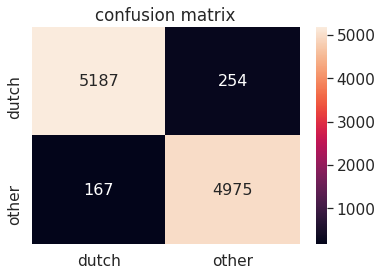

precision: 0.9533174048888072
recall: 0.9688083675756444
f-score: 0.9610004631773968


<Figure size 432x288 with 0 Axes>

In [16]:
import seaborn as sn
import matplotlib.pyplot as plt

cm = [[tp, fp],
      [fn, tn]]

df_cm = pd.DataFrame(cm, ['dutch', 'other'], ['dutch', 'other'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 16}) # font size
plt.title("confusion matrix")
plt.show()
plt.savefig('confusion_matrix.png')

precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f-score: {(2*precision * recall) / (precision + recall)}')


In [17]:
#getting amount of countries that the crawler crawled.

# df = pd.read_csv('data_maxrep.csv')
# countries = df.nl.unique()
# countries = list(filter(lambda x: str(x) != 'nan', countries))
# countries = [a.lower() for a in countries]
# #print(countries)

# countries = [a for a in countries if 'nl' not in a]
# print(len(countries))
# countries = [a for a in countries if 'en' not in a]
# print(len(countries))
# countries = [a for a in countries if 'de' not in a]
# print(len(countries))
# countries = [a for a in countries if 'it' not in a]
# print(len(countries))
# countries = [a for a in countries if 'fr' not in a]
# print(len(countries))
# countries = [a for a in countries if 'be' not in a]
# print(len(countries))
# countries = [a for a in countries if 'pl' not in a]
# print(len(countries))
# countries = [a for a in countries if 'zh' not in a]
# print(len(countries))
# countries = [a for a in countries if 'us' not in a]
# print(len(countries))
# countries = [a for a in countries if 'es' not in a]
# print(len(countries))
# countries = [a for a in countries if 'am' not in a]
# print(len(countries))
# countries = [a for a in countries if 'da' not in a]
# print(len(countries))
# countries = [a for a in countries if 'sl' not in a]
# print(len(countries))
# countries = [a for a in countries if 'ar' not in a]
# print(len(countries))
# countries = [a for a in countries if 'si' not in a]
# print(len(countries))
# countries = [a for a in countries if 'ti' not in a]
# print(len(countries))
# countries = [a for a in countries if 'ja' not in a]
# print(len(countries))
# countries = [a for a in countries if 'ko' not in a]
# print(len(countries))
# countries = [a for a in countries if 'zxx' not in a] #ignore
# print(len(countries))
# countries = [a for a in countries if 'pt' not in a]
# print(len(countries))
# countries = [a for a in countries if 'cn' not in a]
# print(len(countries))
# countries = [a for a in countries if 'tr' not in a]
# print(len(countries))
# countries = [a for a in countries if 'cs' not in a]
# print(len(countries))
# countries = [a for a in countries if 'ca' not in a]
# print(len(countries))
# countries = [a for a in countries if 'el' not in a]
# print(len(countries))
# countries = [a for a in countries if 'gs' not in a]
# print(len(countries))
# countries = [a for a in countries if 'yo' not in a]
# print(len(countries))
# countries = [a for a in countries if 'wu' not in a] #ignore
# print(len(countries))
# countries = [a for a in countries if 'my' not in a]
# print(len(countries))
# countries = [a for a in countries if 'yue' not in a] #ignore
# print(len(countries))
# countries = [a for a in countries if 'ur' not in a]
# print(len(countries))
# countries = [a for a in countries if 'zu' not in a]
# print(len(countries))
# countries = [a for a in countries if 'et' not in a]
# print(len(countries))
# countries = [a for a in countries if 'mt' not in a]
# print(len(countries))
# countries = [a for a in countries if 'ml' not in a]
# print(len(countries))
# countries = [a for a in countries if 'uk' not in a] #ignore
# print(len(countries))
# countries = [a for a in countries if 'ru' not in a]
# print(len(countries))
# countries = [a for a in countries if 'ug' not in a]
# print(len(countries))
# countries = [a for a in countries if 'mn' not in a]
# print(len(countries))
# countries = [a for a in countries if 'sn' not in a]
# print(len(countries))
# countries = [a for a in countries if 'he' not in a]
# print(len(countries))
# countries = [a for a in countries if 'af' not in a]
# print(len(countries))
# countries = [a for a in countries if 'bg' not in a]
# print(len(countries))
# countries = [a for a in countries if 'fa' not in a]
# print(len(countries))
# countries = [a for a in countries if 'bho' not in a]
# print(len(countries))
# countries = [a for a in countries if 'xmf' not in a]
# print(len(countries))
# countries = [a for a in countries if 'mk' not in a]
# print(len(countries))
# countries = [a for a in countries if 'vi' not in a]
# print(len(countries))
# countries = [a for a in countries if 'sr' not in a]
# print(len(countries))
# countries = [a for a in countries if 'cy' not in a]
# print(len(countries))
# countries = [a for a in countries if 'zea' not in a]
# print(len(countries))
# countries = [a for a in countries if 'za' not in a]
# print(len(countries))
# countries = [a for a in countries if 'min' not in a]
# print(len(countries))
# countries = [a for a in countries if 'yi' not in a]
# print(len(countries))
# countries = [a for a in countries if 'azb' not in a]
# print(len(countries))
# countries = [a for a in countries if 'ka' not in a]
# print(len(countries))
# countries = [a for a in countries if 'su' not in a]
# print(len(countries))

# countries = [a for a in countries if 'hak' not in a]
# print(len(countries))
# countries = [a for a in countries if 'gv' not in a]
# print(len(countries))
# countries = [a for a in countries if 'gu' not in a]
# print(len(countries))
# countries = [a for a in countries if 'nov' not in a]
# print(len(countries))
# countries = [a for a in countries if 'fi' not in a]
# print(len(countries))
# countries = [a for a in countries if 'nrf' not in a]
# print(len(countries))
# countries = [a for a in countries if 'uz' not in a]
# print(len(countries))
# countries = [a for a in countries if 'vep' not in a]
# print(len(countries))
# countries = [a for a in countries if 'cv' not in a]
# print(len(countries))
# countries = [a for a in countries if 'dv' not in a]
# print(len(countries))
# countries = [a for a in countries if 'diq' not in a]
# print(len(countries))


# countries = [a for a in countries if 'ro' not in a]
# print(len(countries))
# countries = [a for a in countries if 'krc' not in a]
# print(len(countries))
# countries = [a for a in countries if 'is' not in a]
# print(len(countries))
# countries = [a for a in countries if 'km' not in a]
# print(len(countries))
# countries = [a for a in countries if 'ki' not in a]
# print(len(countries))
# countries = [a for a in countries if 'jv' not in a]
# print(len(countries))
# countries = [a for a in countries if 'kk' not in a]
# print(len(countries))
# countries = [a for a in countries if 'eu' not in a]
# print(len(countries))
# countries = [a for a in countries if 'nds' not in a]
# print(len(countries))
# countries = [a for a in countries if 'br' not in a]
# print(len(countries))
# countries = [a for a in countries if 'mzn' not in a]
# print(len(countries))


# countries = [a for a in countries if 'bs' not in a]
# print(len(countries))
# countries = [a for a in countries if 'cdo' not in a]
# print(len(countries))
# countries = [a for a in countries if 'sh' not in a]
# print(len(countries))
# countries = [a for a in countries if 'szl' not in a]
# print(len(countries))
# countries = [a for a in countries if 'co' not in a]
# print(len(countries))
# countries = [a for a in countries if 'ls' not in a]
# print(len(countries))
# countries = [a for a in countries if 'bj' not in a]
# print(len(countries))
# countries = [a for a in countries if 'no' not in a] #ignore
# print(len(countries))
# countries = [a for a in countries if 'io' not in a]
# print(len(countries))
# countries = [a for a in countries if 'so' not in a]
# print(len(countries))
# countries = [a for a in countries if 'ha' not in a]
# print(len(countries))